In [1]:
import os
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

## Data Loading

In [2]:
image_transforms=transforms.Compose([
    transforms.RandomHorizontalFlip(),## data augumentation
    transforms.RandomRotation(10),  ## data augumentation
    transforms.ColorJitter(brightness=0.2,contrast=0.2),## data augumentation
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [3]:
dataset_path="./dataset"
dataset=datasets.ImageFolder(root=dataset_path,transform=image_transforms)
len(dataset)

2300

In [32]:
classes_names=dataset.classes

In [33]:
classes_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [5]:
train_size=int(0.75*len(dataset))
train_size

1725

In [6]:
val_size=len(dataset)-train_size

val_size

575

In [7]:
from torch.utils.data import random_split
train_dataset,val_dataset=random_split(dataset,[train_size,val_size])

In [8]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=True)

In [9]:
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [10]:
images[0].shape

torch.Size([3, 224, 224])

In [11]:
labels[0]

tensor(4)

In [12]:
images[0].permute(1,2,0).shape ## changes [3,224,224]->[224,224,3]

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


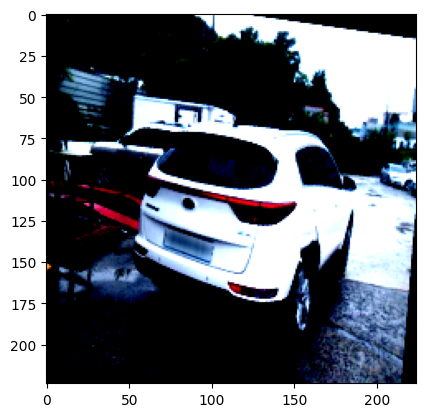

In [13]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


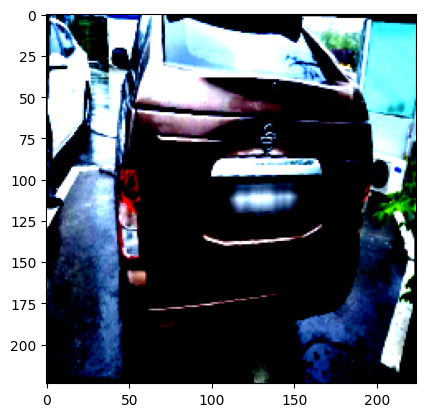

In [14]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

## CNN

In [15]:
class carclassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),## (16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # (16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),## (32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # (32,56,56)
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),## (64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),# (64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )
    def forward(self,x):
        x=self.network(x)
        return x

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
model=carclassifierCNN(num_classes=6).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [18]:
images.size(0)

32

In [19]:
len(train_loader.dataset)

1725

In [20]:
def train_model(model,criterion,optimizer,epochs=5):
    start=time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss=0
        for batch_num,(images,labels) in enumerate(train_loader):
            images,labels=images.to(device),labels.to(device)
            optimizer.zero_grad()
            # forward pass
            outputs=model(images)
            loss=criterion(outputs,labels)
            # backward and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1)%10==0:
                print(f"batch: {batch_num+1},epoch:{epoch+1},loss:{loss.item():0.2f}")

            running_loss+=loss.item()*images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        #validation
        model.eval()
        correct=0
        total=0
        all_labels=[]
        all_predictions=[]
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels=images.to(device),labels.to(device)
                outputs=model(images)
                _,predicted=torch.max(outputs.data,1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    return all_labels, all_predictions

In [21]:
train_model(model,criterion,optimizer,epochs=5)

batch: 10,epoch:1,loss:1.76
batch: 20,epoch:1,loss:1.71
batch: 30,epoch:1,loss:1.43
batch: 40,epoch:1,loss:1.22
batch: 50,epoch:1,loss:1.41
Epoch [1/5], Avg Loss: 1.8174
*** Validation Accuracy: 45.22% ***
batch: 10,epoch:2,loss:1.06
batch: 20,epoch:2,loss:1.19
batch: 30,epoch:2,loss:1.48
batch: 40,epoch:2,loss:1.23
batch: 50,epoch:2,loss:0.94
Epoch [2/5], Avg Loss: 1.2207
*** Validation Accuracy: 50.96% ***
batch: 10,epoch:3,loss:1.19
batch: 20,epoch:3,loss:0.96
batch: 30,epoch:3,loss:1.12
batch: 40,epoch:3,loss:1.17
batch: 50,epoch:3,loss:1.22
Epoch [3/5], Avg Loss: 1.0543
*** Validation Accuracy: 53.39% ***
batch: 10,epoch:4,loss:0.90
batch: 20,epoch:4,loss:1.04
batch: 30,epoch:4,loss:1.09
batch: 40,epoch:4,loss:0.93
batch: 50,epoch:4,loss:0.68
Epoch [4/5], Avg Loss: 0.9573
*** Validation Accuracy: 58.43% ***
batch: 10,epoch:5,loss:0.91
batch: 20,epoch:5,loss:0.97
batch: 30,epoch:5,loss:0.83
batch: 40,epoch:5,loss:0.91
batch: 50,epoch:5,loss:0.82
Epoch [5/5], Avg Loss: 0.9080
*** Va

([2,
  4,
  2,
  3,
  1,
  2,
  1,
  3,
  2,
  1,
  2,
  4,
  0,
  2,
  0,
  3,
  3,
  2,
  4,
  2,
  4,
  4,
  1,
  2,
  1,
  5,
  5,
  4,
  0,
  2,
  3,
  2,
  4,
  0,
  5,
  1,
  2,
  2,
  4,
  5,
  1,
  5,
  3,
  3,
  2,
  2,
  0,
  0,
  0,
  3,
  1,
  0,
  0,
  2,
  4,
  0,
  1,
  0,
  2,
  0,
  5,
  5,
  1,
  3,
  2,
  4,
  0,
  1,
  4,
  2,
  5,
  0,
  1,
  0,
  2,
  0,
  5,
  5,
  1,
  3,
  1,
  2,
  1,
  1,
  3,
  0,
  0,
  1,
  5,
  4,
  0,
  1,
  3,
  2,
  3,
  3,
  2,
  5,
  3,
  4,
  2,
  3,
  0,
  4,
  1,
  2,
  1,
  2,
  0,
  0,
  5,
  0,
  3,
  1,
  5,
  1,
  5,
  1,
  4,
  3,
  0,
  2,
  2,
  5,
  4,
  3,
  1,
  4,
  3,
  5,
  3,
  1,
  0,
  0,
  2,
  4,
  0,
  2,
  4,
  2,
  4,
  0,
  1,
  2,
  1,
  0,
  2,
  2,
  2,
  0,
  5,
  1,
  3,
  0,
  3,
  4,
  2,
  4,
  2,
  2,
  2,
  0,
  0,
  1,
  0,
  5,
  4,
  3,
  5,
  1,
  1,
  0,
  2,
  4,
  1,
  3,
  2,
  4,
  2,
  2,
  4,
  4,
  3,
  3,
  2,
  2,
  2,
  4,
  2,
  3,
  2,
  5,
  1,
  1,
  1,
  2,
  3,
  3,
  0,
  2,


In [22]:
## here model is overfitting 

## CNN with regularization

In [21]:
class carclassifierCNNRegularization(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),## (16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # (16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),## (32,112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # (32,56,56)
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),## (64,56,56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),# (64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)
        )
    def forward(self,x):
        x=self.network(x)
        return x

In [24]:
model=carclassifierCNNRegularization(num_classes=6).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4) # weight_decay ->L2 regilarization

train_model(model,criterion,optimizer,epochs=10)

batch: 10,epoch:1,loss:14.11
batch: 20,epoch:1,loss:3.97
batch: 30,epoch:1,loss:1.40
batch: 40,epoch:1,loss:1.75
batch: 50,epoch:1,loss:1.62
Epoch [1/10], Avg Loss: 6.5396
*** Validation Accuracy: 45.74% ***
batch: 10,epoch:2,loss:1.62
batch: 20,epoch:2,loss:1.41
batch: 30,epoch:2,loss:1.33
batch: 40,epoch:2,loss:1.40
batch: 50,epoch:2,loss:1.57
Epoch [2/10], Avg Loss: 1.4166
*** Validation Accuracy: 49.22% ***
batch: 10,epoch:3,loss:1.42
batch: 20,epoch:3,loss:1.28
batch: 30,epoch:3,loss:1.46
batch: 40,epoch:3,loss:1.12
batch: 50,epoch:3,loss:1.27
Epoch [3/10], Avg Loss: 1.3112
*** Validation Accuracy: 51.83% ***
batch: 10,epoch:4,loss:1.13
batch: 20,epoch:4,loss:1.11
batch: 30,epoch:4,loss:1.33
batch: 40,epoch:4,loss:1.18
batch: 50,epoch:4,loss:1.09
Epoch [4/10], Avg Loss: 1.2818
*** Validation Accuracy: 50.43% ***
batch: 10,epoch:5,loss:1.30
batch: 20,epoch:5,loss:1.34
batch: 30,epoch:5,loss:1.23
batch: 40,epoch:5,loss:1.15
batch: 50,epoch:5,loss:1.51
Epoch [5/10], Avg Loss: 1.2393


([2,
  2,
  2,
  2,
  0,
  1,
  5,
  4,
  4,
  2,
  2,
  4,
  1,
  5,
  0,
  0,
  3,
  3,
  1,
  1,
  1,
  1,
  0,
  1,
  3,
  0,
  2,
  4,
  0,
  5,
  1,
  2,
  2,
  4,
  2,
  3,
  4,
  1,
  4,
  2,
  2,
  2,
  2,
  2,
  1,
  5,
  4,
  3,
  2,
  3,
  0,
  0,
  1,
  0,
  5,
  3,
  0,
  3,
  2,
  0,
  4,
  4,
  5,
  4,
  0,
  0,
  1,
  2,
  1,
  4,
  0,
  3,
  2,
  2,
  2,
  3,
  1,
  3,
  2,
  3,
  5,
  5,
  0,
  2,
  1,
  1,
  5,
  5,
  1,
  2,
  0,
  3,
  1,
  0,
  2,
  3,
  1,
  0,
  1,
  2,
  3,
  0,
  1,
  1,
  3,
  2,
  0,
  1,
  0,
  2,
  1,
  2,
  3,
  2,
  4,
  5,
  3,
  1,
  3,
  2,
  3,
  3,
  1,
  1,
  3,
  5,
  0,
  0,
  5,
  1,
  5,
  3,
  1,
  4,
  1,
  1,
  4,
  5,
  0,
  3,
  1,
  2,
  4,
  5,
  2,
  5,
  0,
  2,
  5,
  1,
  0,
  2,
  0,
  3,
  4,
  5,
  2,
  5,
  3,
  1,
  4,
  2,
  2,
  2,
  3,
  2,
  4,
  2,
  1,
  2,
  4,
  2,
  2,
  3,
  4,
  2,
  4,
  2,
  4,
  5,
  3,
  2,
  1,
  4,
  2,
  1,
  0,
  0,
  3,
  4,
  1,
  5,
  2,
  1,
  2,
  0,
  5,
  2,
  2,
  5,


## Transfer learning with EfficientNet

In [22]:
model=models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [23]:
class carClassifierEfficientNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model=models.efficientnet_b0(weights="DEFAULT")
        
        for param in self.model.parameters():
            param.requires_grad=False
            
        in_features=self.model.classifier[1].in_features
        self.model.classifier=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features,num_classes)
        )
    def forward(self,x):
        x=self.model(x)
        return x

In [29]:
model=carClassifierEfficientNet(num_classes=6).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.001) # weight_decay ->L2 regilarization

train_model(model,criterion,optimizer,epochs=7)

batch: 10,epoch:1,loss:1.61
batch: 20,epoch:1,loss:1.51
batch: 30,epoch:1,loss:1.44
batch: 40,epoch:1,loss:1.40
batch: 50,epoch:1,loss:1.25
Epoch [1/7], Avg Loss: 1.4812
*** Validation Accuracy: 54.96% ***
batch: 10,epoch:2,loss:1.00
batch: 20,epoch:2,loss:1.12
batch: 30,epoch:2,loss:1.02
batch: 40,epoch:2,loss:1.31
batch: 50,epoch:2,loss:1.20
Epoch [2/7], Avg Loss: 1.1490
*** Validation Accuracy: 62.26% ***
batch: 10,epoch:3,loss:1.03
batch: 20,epoch:3,loss:0.95
batch: 30,epoch:3,loss:1.05
batch: 40,epoch:3,loss:1.18
batch: 50,epoch:3,loss:0.98
Epoch [3/7], Avg Loss: 1.0191
*** Validation Accuracy: 63.48% ***
batch: 10,epoch:4,loss:0.96
batch: 20,epoch:4,loss:1.02
batch: 30,epoch:4,loss:0.98
batch: 40,epoch:4,loss:0.96
batch: 50,epoch:4,loss:0.94
Epoch [4/7], Avg Loss: 0.9636
*** Validation Accuracy: 67.48% ***
batch: 10,epoch:5,loss:0.91
batch: 20,epoch:5,loss:0.86
batch: 30,epoch:5,loss:0.82
batch: 40,epoch:5,loss:0.87
batch: 50,epoch:5,loss:0.93
Epoch [5/7], Avg Loss: 0.9125
*** Va

([0,
  2,
  1,
  1,
  2,
  1,
  4,
  5,
  0,
  5,
  2,
  0,
  4,
  2,
  5,
  5,
  2,
  3,
  2,
  1,
  1,
  1,
  0,
  2,
  1,
  1,
  0,
  2,
  0,
  2,
  5,
  0,
  2,
  1,
  4,
  2,
  0,
  0,
  1,
  5,
  0,
  4,
  5,
  0,
  0,
  3,
  0,
  2,
  1,
  0,
  0,
  0,
  5,
  3,
  0,
  3,
  1,
  4,
  1,
  1,
  2,
  0,
  2,
  4,
  4,
  2,
  3,
  3,
  1,
  3,
  3,
  0,
  2,
  1,
  2,
  1,
  2,
  0,
  0,
  2,
  2,
  0,
  5,
  1,
  0,
  3,
  0,
  2,
  5,
  0,
  5,
  5,
  1,
  3,
  1,
  0,
  1,
  0,
  4,
  0,
  0,
  0,
  3,
  5,
  2,
  4,
  2,
  0,
  1,
  3,
  5,
  2,
  1,
  1,
  3,
  2,
  1,
  1,
  0,
  0,
  0,
  2,
  2,
  2,
  0,
  2,
  1,
  2,
  3,
  1,
  1,
  4,
  4,
  3,
  5,
  0,
  3,
  0,
  1,
  2,
  1,
  4,
  4,
  3,
  3,
  2,
  1,
  1,
  0,
  5,
  3,
  5,
  2,
  5,
  2,
  1,
  0,
  3,
  1,
  1,
  0,
  5,
  2,
  1,
  4,
  4,
  0,
  1,
  5,
  0,
  4,
  0,
  3,
  0,
  0,
  5,
  2,
  0,
  0,
  4,
  4,
  2,
  4,
  1,
  0,
  1,
  0,
  2,
  3,
  0,
  1,
  4,
  0,
  2,
  1,
  4,
  4,
  1,
  2,
  3,


### Transfer Learning with ResNet

In [24]:

# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [34]:
model = CarClassifierResNet(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model, criterion, optimizer, epochs=5)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Siddu/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [01:56<00:00, 879kB/s]


batch: 10,epoch:1,loss:1.05
batch: 20,epoch:1,loss:0.80
batch: 30,epoch:1,loss:0.67
batch: 40,epoch:1,loss:0.51
batch: 50,epoch:1,loss:0.66
Epoch [1/5], Avg Loss: 0.8994
*** Validation Accuracy: 70.61% ***
batch: 10,epoch:2,loss:0.30
batch: 20,epoch:2,loss:0.57
batch: 30,epoch:2,loss:0.50
batch: 40,epoch:2,loss:0.41
batch: 50,epoch:2,loss:0.45
Epoch [2/5], Avg Loss: 0.4949
*** Validation Accuracy: 78.26% ***
batch: 10,epoch:3,loss:0.37
batch: 20,epoch:3,loss:0.33
batch: 30,epoch:3,loss:0.26
batch: 40,epoch:3,loss:0.57
batch: 50,epoch:3,loss:0.31
Epoch [3/5], Avg Loss: 0.3405
*** Validation Accuracy: 77.91% ***
batch: 10,epoch:4,loss:0.18
batch: 20,epoch:4,loss:0.27
batch: 30,epoch:4,loss:0.18
batch: 40,epoch:4,loss:0.24
batch: 50,epoch:4,loss:0.22
Epoch [4/5], Avg Loss: 0.2775
*** Validation Accuracy: 78.43% ***
batch: 10,epoch:5,loss:0.12
batch: 20,epoch:5,loss:0.28
batch: 30,epoch:5,loss:0.31
batch: 40,epoch:5,loss:0.24
batch: 50,epoch:5,loss:0.08
Epoch [5/5], Avg Loss: 0.1887
*** Va

([2,
  2,
  0,
  1,
  0,
  4,
  2,
  2,
  2,
  1,
  2,
  3,
  2,
  5,
  3,
  0,
  1,
  3,
  3,
  2,
  0,
  0,
  2,
  5,
  0,
  3,
  2,
  3,
  0,
  4,
  0,
  2,
  4,
  1,
  0,
  1,
  3,
  0,
  3,
  0,
  5,
  5,
  2,
  1,
  1,
  3,
  2,
  4,
  3,
  2,
  0,
  1,
  0,
  5,
  2,
  5,
  0,
  3,
  4,
  2,
  1,
  4,
  5,
  1,
  3,
  0,
  4,
  2,
  0,
  2,
  5,
  0,
  3,
  4,
  3,
  1,
  0,
  0,
  2,
  2,
  4,
  2,
  3,
  4,
  0,
  0,
  2,
  5,
  1,
  0,
  2,
  4,
  3,
  0,
  4,
  4,
  1,
  0,
  5,
  1,
  0,
  4,
  3,
  3,
  2,
  0,
  4,
  2,
  0,
  1,
  2,
  3,
  4,
  1,
  5,
  4,
  0,
  3,
  0,
  4,
  3,
  2,
  0,
  5,
  0,
  0,
  4,
  2,
  0,
  2,
  3,
  4,
  0,
  2,
  4,
  4,
  0,
  5,
  0,
  5,
  1,
  2,
  0,
  5,
  2,
  2,
  0,
  3,
  3,
  2,
  4,
  3,
  4,
  0,
  1,
  0,
  5,
  2,
  0,
  0,
  1,
  1,
  1,
  5,
  2,
  0,
  4,
  5,
  1,
  0,
  2,
  3,
  2,
  5,
  0,
  3,
  2,
  2,
  2,
  5,
  2,
  0,
  1,
  3,
  0,
  1,
  4,
  1,
  1,
  4,
  2,
  2,
  0,
  2,
  0,
  3,
  1,
  2,
  2,
  2,


In [25]:
model = CarClassifierResNet(num_classes=6,dropout_rate=0.5240949625392353).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0013017355110099633)

labels,predictions=train_model(model, criterion, optimizer, epochs=5)

batch: 10,epoch:1,loss:1.00
batch: 20,epoch:1,loss:0.86
batch: 30,epoch:1,loss:0.70
batch: 40,epoch:1,loss:0.99
batch: 50,epoch:1,loss:0.88
Epoch [1/5], Avg Loss: 0.8936
*** Validation Accuracy: 68.17% ***
batch: 10,epoch:2,loss:0.71
batch: 20,epoch:2,loss:0.55
batch: 30,epoch:2,loss:0.40
batch: 40,epoch:2,loss:0.33
batch: 50,epoch:2,loss:0.47
Epoch [2/5], Avg Loss: 0.4673
*** Validation Accuracy: 80.00% ***
batch: 10,epoch:3,loss:0.27
batch: 20,epoch:3,loss:0.37
batch: 30,epoch:3,loss:0.51
batch: 40,epoch:3,loss:0.30
batch: 50,epoch:3,loss:0.52
Epoch [3/5], Avg Loss: 0.3431
*** Validation Accuracy: 73.57% ***
batch: 10,epoch:4,loss:0.36
batch: 20,epoch:4,loss:0.41
batch: 30,epoch:4,loss:0.47
batch: 40,epoch:4,loss:0.17
batch: 50,epoch:4,loss:0.28
Epoch [4/5], Avg Loss: 0.3063
*** Validation Accuracy: 78.26% ***
batch: 10,epoch:5,loss:0.11
batch: 20,epoch:5,loss:0.31
batch: 30,epoch:5,loss:0.40
batch: 40,epoch:5,loss:0.12
batch: 50,epoch:5,loss:0.41
Epoch [5/5], Avg Loss: 0.2147
*** Va

In [26]:
labels[:5],predictions[:5]

([0, 5, 3, 3, 3], [0, 4, 3, 3, 4])

In [29]:
from sklearn.metrics import classification_report
report=classification_report(labels,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       140
           1       0.69      0.84      0.76        87
           2       0.95      0.88      0.91       120
           3       0.75      0.83      0.79        66
           4       0.76      0.66      0.71        86
           5       0.80      0.78      0.79        76

    accuracy                           0.82       575
   macro avg       0.81      0.81      0.81       575
weighted avg       0.83      0.82      0.82       575



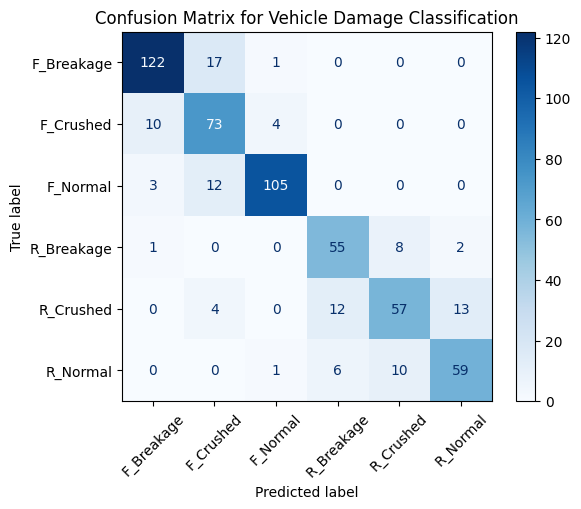

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [35]:
torch.save(model.state_dict(),"saved_model.pth")